# Introduction

# Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [ ]:
# load the dataset
features_path = "data/features.csv"
stores_path = "data/stores.csv"
train_path = "data/train.csv"
test_path = "data/test.csv"
features = pd.read_csv(features_path)
stores = pd.read_csv(stores_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [ ]:
# display baisc information.
print("Features:")
print(features.info())
print("\nStores:")
print(stores.info())
print("\nTrain:")
print(train.info())
print("\nTest:")
print(test.info())

Features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None

Stores:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-

- Before merging, the dataset consists of four files: features.csv, stores.csv, train.csv, and test.csv. The features.csv dataset provides store-level information such as markdowns, temperature, and economic indicators, but contains missing values, especially in the markdown columns.

- The stores.csv dataset offers metadata about 45 stores, including their type and size, with no missing values.

- The train.csv dataset contains over 420,000 rows of historical weekly sales data, including store and department identifiers, and as the primary dataset for analysis and prediction.

-  The test.csv dataset, with similar structure to the training data but without sales values, is used for forecasting purposes.


In [ ]:
# convert the datatype for merge
features['Date'] = pd.to_datetime(features['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

features['Store'] = features['Store'].astype(int)
stores['Store'] = stores['Store'].astype(int)
train['Store'] = train['Store'].astype(int)
test['Store'] = test['Store'].astype(int)

In [ ]:
# handle Markdown(1-5) missing value with 0.
Markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
features[Markdown_columns] = features[Markdown_columns].fillna(0)

# Fill missing CPI and Unemployment using forward-fill/backward-fill based on date
features['CPI'] = features['CPI'].ffill().bfill()
features['Unemployment'] = features['Unemployment'].ffill().bfill()

# check the missing value again.
features.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

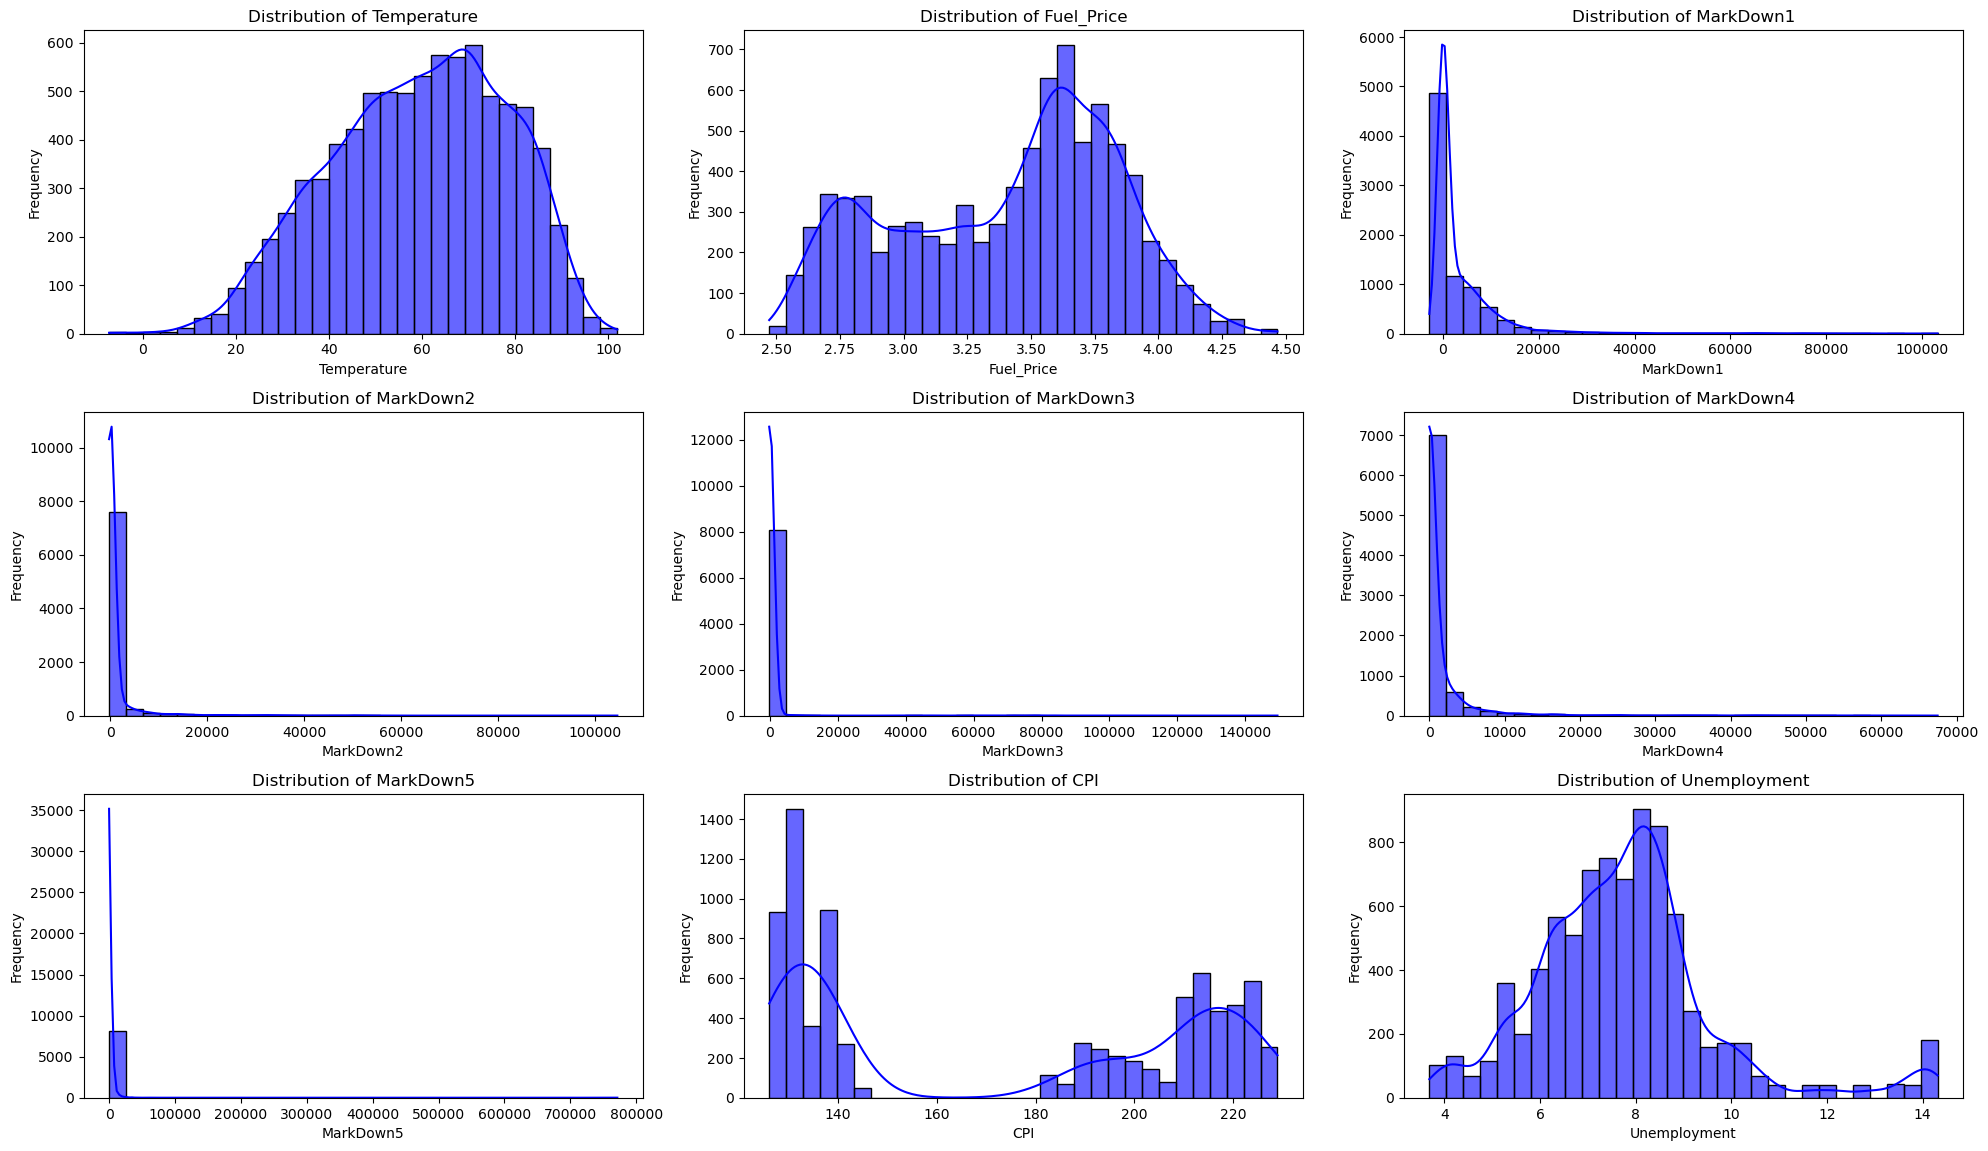

In [ ]:
# distribution of numeric features.
numerical_columns = [
   'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'
]
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 3, i + 1)
    sns.histplot(features[col], kde=True, bins=30, color='blue', alpha=0.6)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Temperature and fuel prices exhibit near-normal distributions, with most values falling within expected ranges, while markdown variables (MarkDown1-5) are heavily right-skewed, with many zero values and a few high outliers, reflecting irregular promotional activities.

CPI shows a dual-peak distribution, indicating variations across regions and periods, and unemployment is centered around 8%, reflecting economic conditions during the dataset's timeframe.


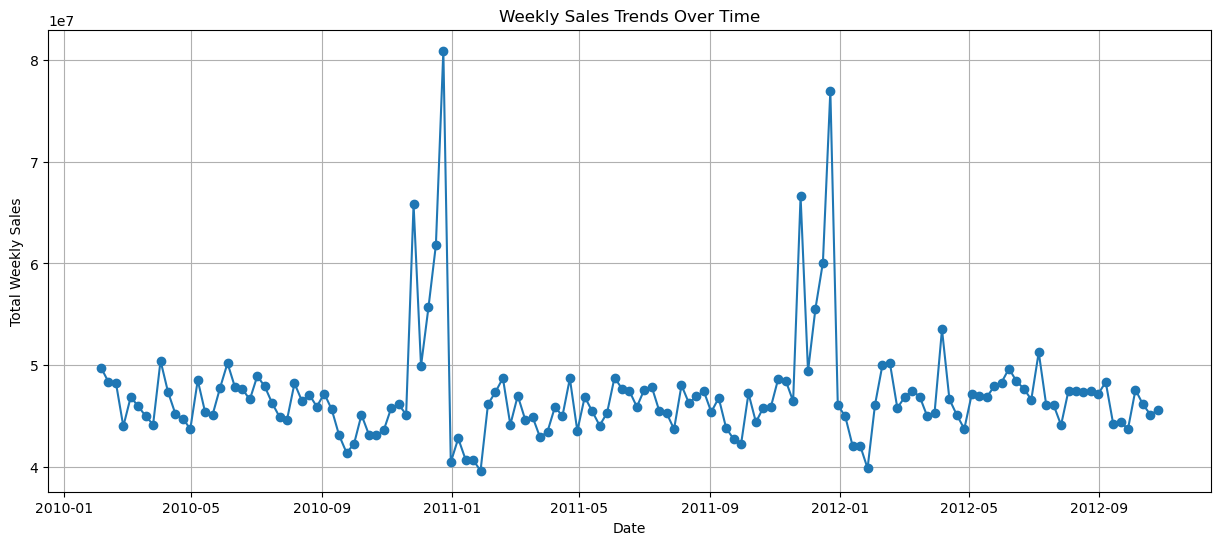

In [ ]:
# weekly sales over time
sales_over_time = train.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(sales_over_time['Date'], sales_over_time['Weekly_Sales'], marker='o')
plt.title("Weekly Sales Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.grid()
plt.show()

- The line chart shows a pattern of peaks at the end of each year, corresponding to holiday seasons such as Thanksgiving, Black Friday, and Christmas. These peaks result in large increases in sales. Between these peaks, the sales remain relatively stable, with minor fluctuations.

- The overall pattern indicates strong seasonality in Walmart's sales and highlights the importance of these events in driving revenue. These trends suggest that seasonality should be accounted for in forecasting models.


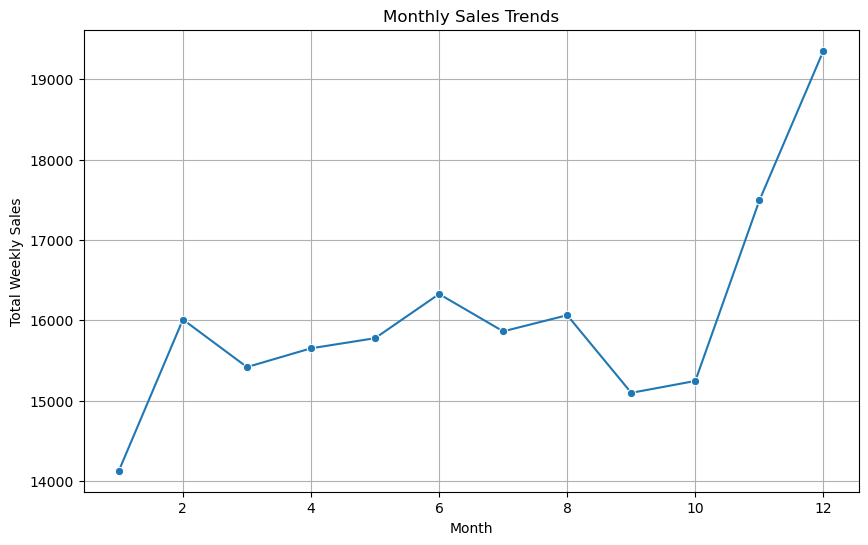

In [ ]:
# Extract month from the date
month_sale_df = train.copy()
month_sale_df['Month'] = month_sale_df['Date'].dt.month


# Monthly sales trend
monthly_sales = month_sale_df.groupby('Month')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Weekly_Sales', marker='o')
plt.title("Monthly Sales Trends")
plt.xlabel("Month")
plt.ylabel("Total Weekly Sales")
plt.grid()
plt.show()

- This line chart illustrates monthly sales trends, showing a steady increase towards December. The total weekly sales experience a notable spike in December, likely due to holiday shopping, while there is a decline during the later summer and early autumn months. These trends emphasise the importance of seasonality in Walmart's sales, indicating that both weather and holiday-related factors impact monthly sales performance.

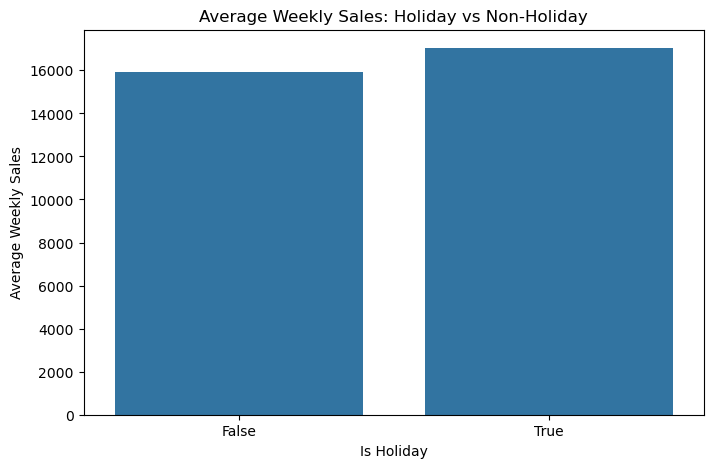

In [ ]:
# Average sales on holidays vs non-holidays
holiday_sales = train.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=holiday_sales, x='IsHoliday', y='Weekly_Sales')
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.xlabel("Is Holiday")
plt.ylabel("Average Weekly Sales")
plt.show()

- The bar chart shows that the average weekly sales are higher during holiday weeks compared to non-holiday weeks. This further indicates the significant impact of holidays on sales performance.



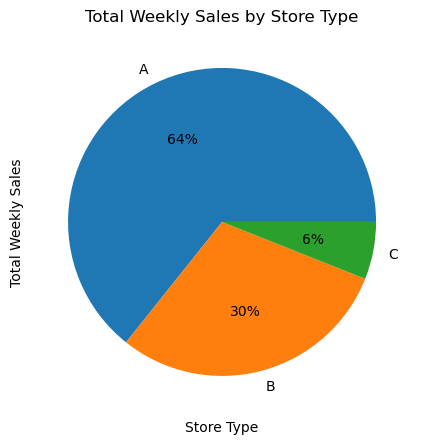

In [ ]:
# Sales by store type

store_sales_df = train.merge(stores, on='Store')
store_type_sales = store_sales_df.groupby('Type')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.pie(store_type_sales['Weekly_Sales'], labels=store_type_sales['Type'],autopct='%.0f%%' )
# sns.barplot(data=store_type_sales, x='Type', y='Weekly_Sales')
plt.title("Total Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Total Weekly Sales")
plt.show()

This pie chart shows the total weekly sales for each store type (A, B, and C).Type A stores, the largest in size, have higher total sales than Types B and C. This is likely due to their greater capacity and higher customer traffic. This highlights the importance of store type in sales and its potential impact on predictive modeling.

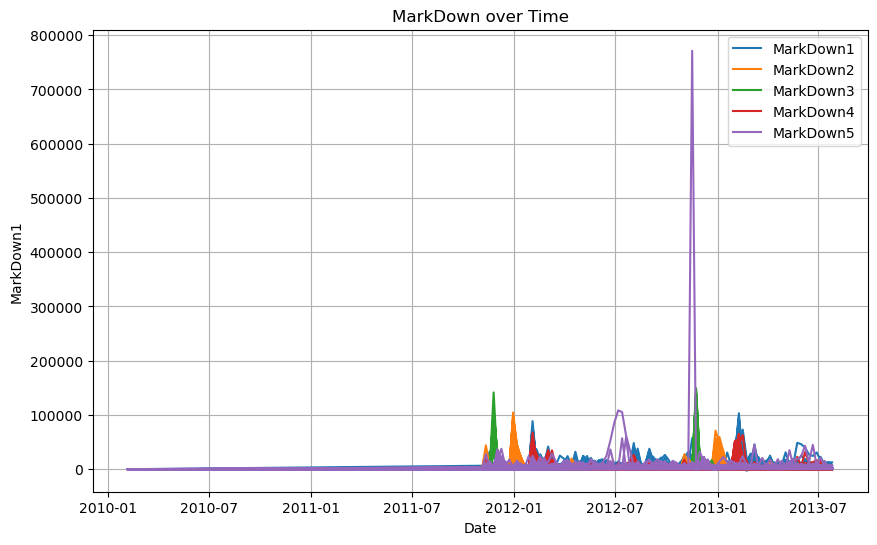

In [ ]:
# features.sort_values(by="Date", inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(features['Date'], features['MarkDown1'], label='MarkDown1')
plt.plot(features['Date'], features['MarkDown2'], label='MarkDown2')
plt.plot(features['Date'], features['MarkDown3'], label='MarkDown3')
plt.plot(features['Date'], features['MarkDown4'], label='MarkDown4')
plt.plot(features['Date'], features['MarkDown5'], label='MarkDown5')
plt.title('MarkDown over Time')
plt.xlabel('Date')
plt.ylabel('MarkDown1')
plt.legend()
plt.grid(True)
plt.show()

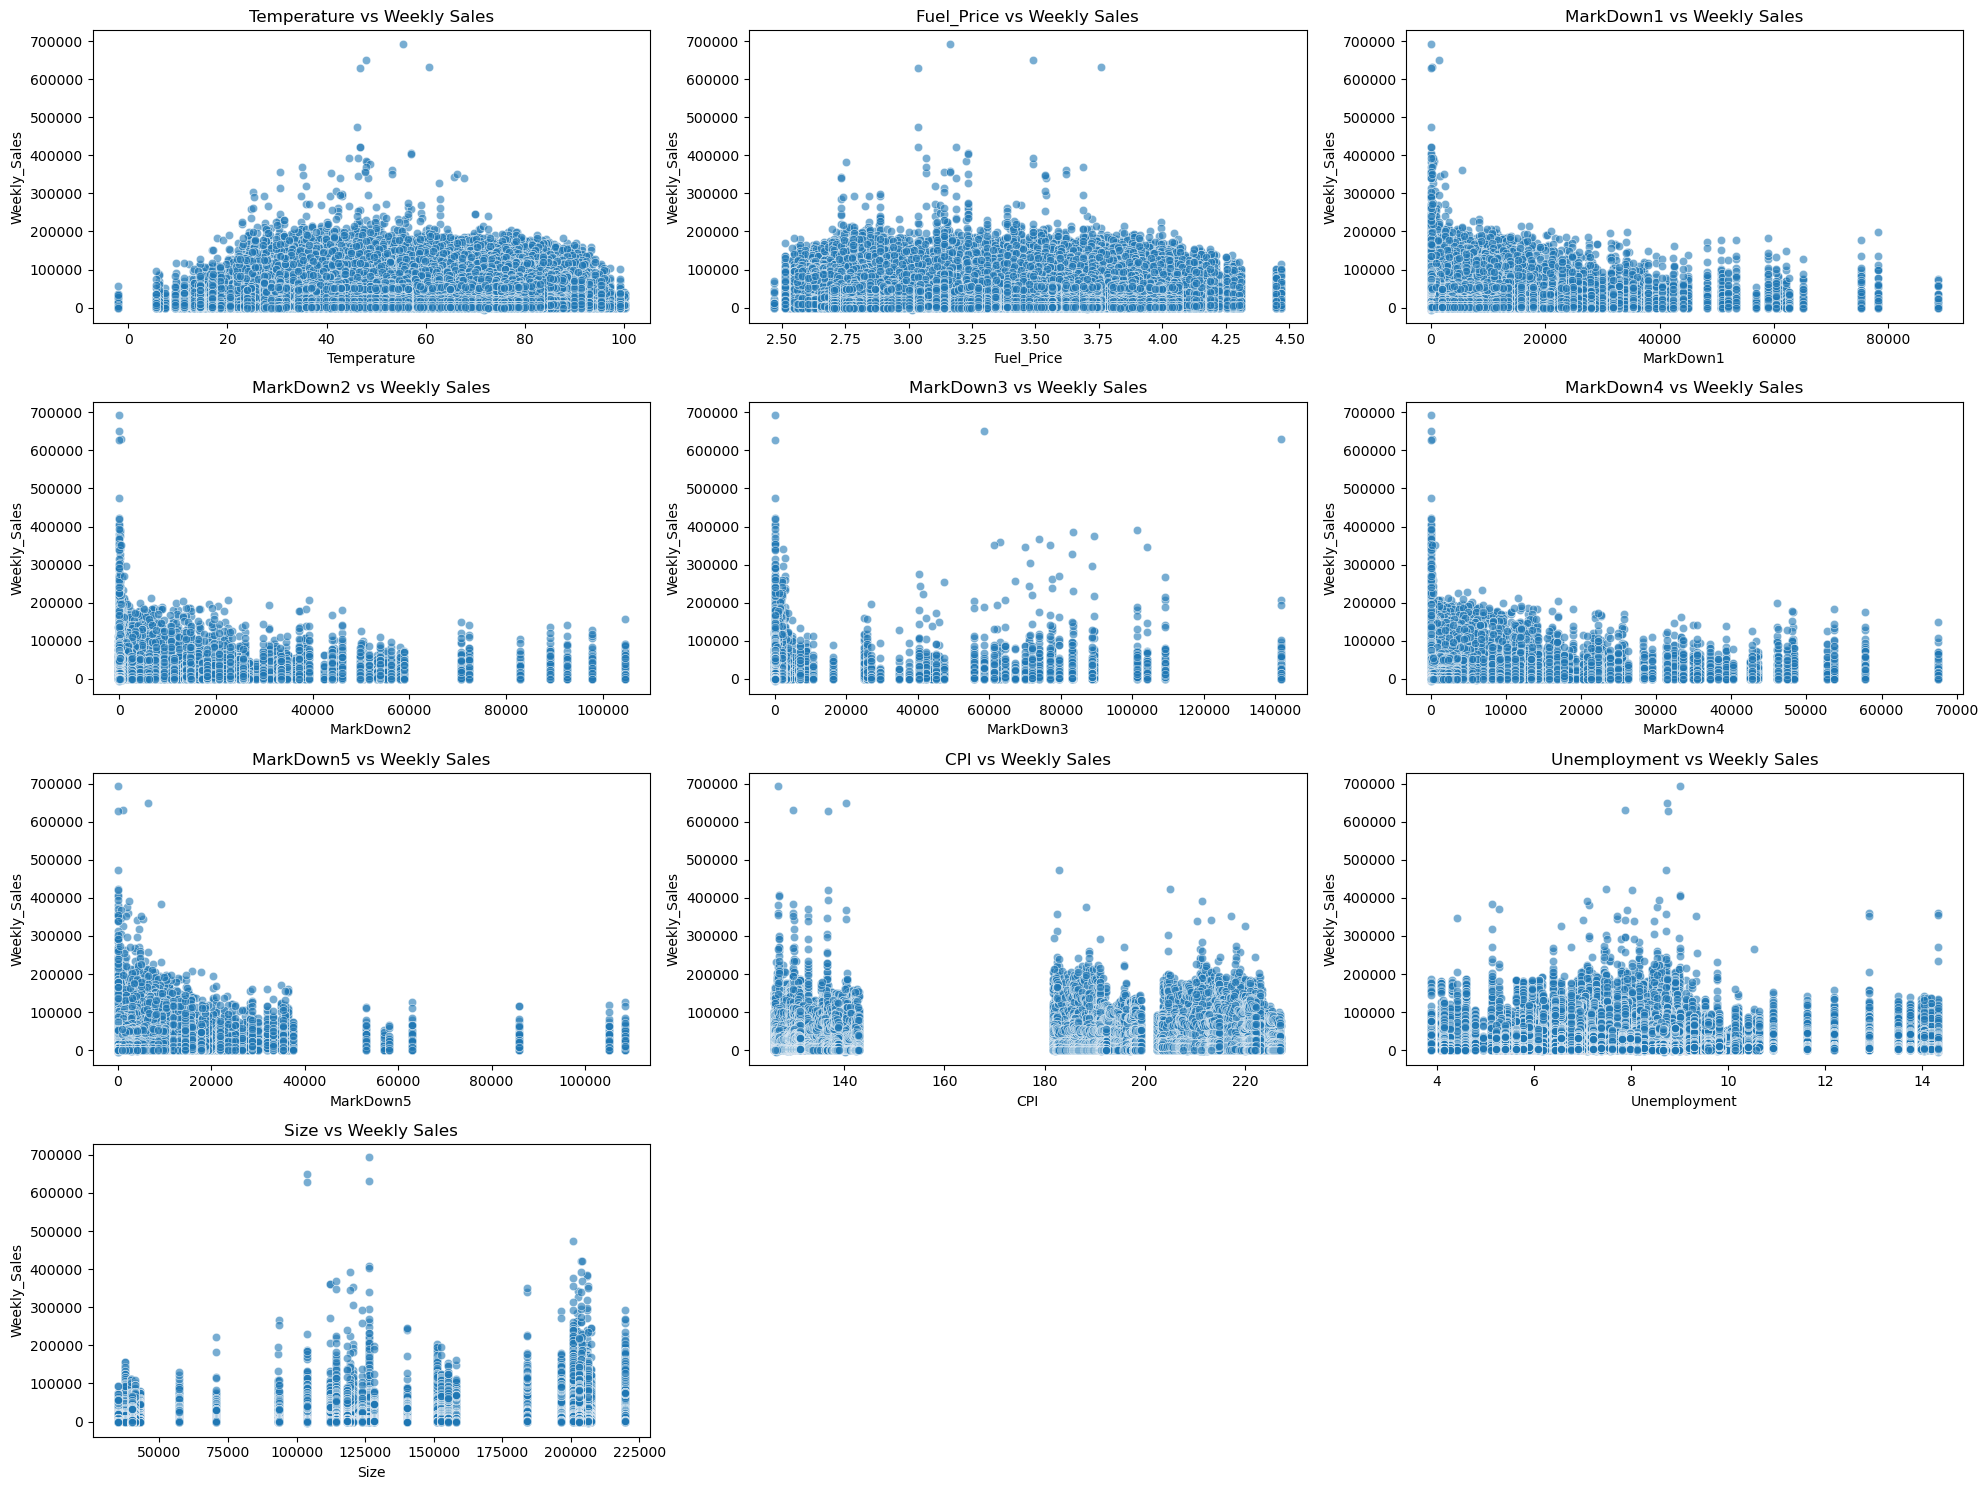

In [ ]:
train_full = train.merge(features, on=['Store', 'Date', 'IsHoliday']).merge(stores, on='Store')
numerical_columns = [
   'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
    'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size'
]
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_columns):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=train_full[col], y=train_full["Weekly_Sales"], alpha=0.6)
    plt.title(f"{col} vs Weekly Sales")
    plt.xlabel(col)
    plt.ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()

The temperature scatter plot indicates a clustering of sales around moderate levels, which suggests potential seasonality. While promotions occasionally drive higher sales, the majority of data points cluster around zero markdown activity. There is a positive relationship between store size and sales, with larger stores generating higher weekly sales. However, features such as fuel price, CPI, and unemployment show no strong or consistent patterns with sales, indicating limited direct influence. Next will use a heatmap for further check.

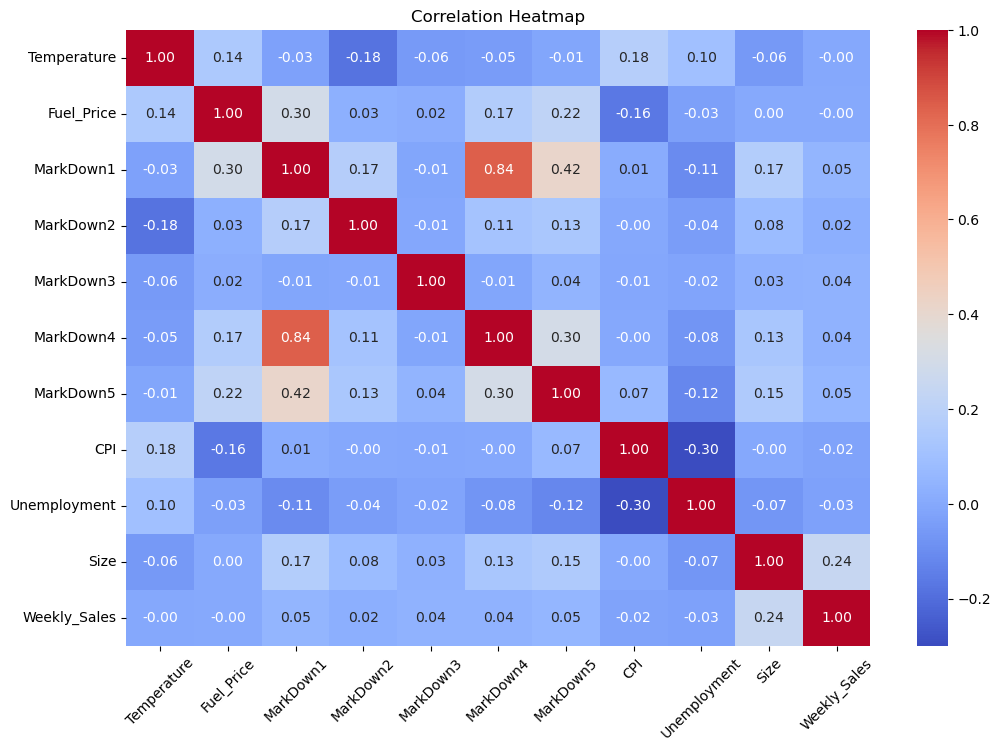

In [ ]:
# correlation matrix
correlation_matrix = train_full[numerical_columns + ['Weekly_Sales']].corr()
# Heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

**Key Influential Factors:** Store size shows the strongest positive correlation with weekly sales, indicating that larger stores tend to achieve higher sales.

**Promotional Impact**: Markdown features (MarkDown1, MarkDown4, MarkDown5) have weak positive correlations with sales, highlighting a limited but noticeable effect from promotions.

 **Minimal Impact Factors:** Variables such as temperature, fuel price, unemployment, and CPI have near-zero correlations with weekly sales, suggesting minimal direct influence on sales performance.

**Complex Relationships:** The low overall correlations imply that sales prediction depends on complex, non-linear interactions between features.


# Data Preprocessing

In [ ]:
# Group data by 'Store' and 'Dept', and calculate summary statistics ('max', 'min', 'mean', 'median', 'std') for 'Weekly_Sales'
agg_data = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
# Merge the aggregated data back with the original dataset on 'Store' and 'Dept' columns, using a left join
train_agg_df = train_full.merge(agg_data, on=['Store', 'Dept'], how='left')
# Remove the markdown-related columns from the original dataset as they are no longer needed
train_full.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)
# Convert the 'IsHoliday' column to integer format for easier processing (e.g., 0 for False, 1 for True)
train_agg_df['IsHoliday'] = train_agg_df['IsHoliday'].astype(int)
# Extract year, month, and day components from the 'Date' column to create separate features
train_agg_df['year'] = train_agg_df['Date'].dt.year
train_agg_df['month'] = train_agg_df['Date'].dt.month
train_agg_df['day'] = train_agg_df['Date'].dt.day
# Drop the 'Date' column since its components have already been extracted and the full date is no longer needed
train_agg_df.drop('Date', axis=1, inplace=True)
# Display the first few rows
train_agg_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Type,Size,max,min,mean,median,std,year,month,day
0,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,...,A,151315,57592.12,14537.37,22513.322937,18535.48,9854.349032,2010,2,5
1,1,1,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,...,A,151315,57592.12,14537.37,22513.322937,18535.48,9854.349032,2010,2,12
2,1,1,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,...,A,151315,57592.12,14537.37,22513.322937,18535.48,9854.349032,2010,2,19
3,1,1,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,...,A,151315,57592.12,14537.37,22513.322937,18535.48,9854.349032,2010,2,26
4,1,1,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,...,A,151315,57592.12,14537.37,22513.322937,18535.48,9854.349032,2010,3,5


In [ ]:
# Initialize a MinMaxScaler to scale numerical features between 0 and 1
scaler = MinMaxScaler()
# Separate features (X) and target variable (y) from the dataset
X, y = train_agg_df.drop(['Weekly_Sales', 'Type'], axis=1), train_agg_df['Weekly_Sales']
# Fill any missing values in the feature set with 0 to avoid issues during model training
X.fillna(0, inplace=True)
# Specify columns that should not be scaled, such as categorical or identifier columns
not_to_scale = ['Store', 'Dept']
# Identify columns to scale (all columns except those in 'not_to_scale')
to_scale = [col for col in X.columns if col not in not_to_scale]
# Apply MinMaxScaler only to the selected columns
X[to_scale] = scaler.fit_transform(X[to_scale])
# Split the dataset into training and testing sets (80% train, 20% test) for model evaluation
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize an empty list to store model performance metrics for later comparison
model_performance = []

In [ ]:
# Initialize a Linear Regression model
linear_regression = LinearRegression()
# Train the model using the training data, excluding 'Store' and 'Dept' as they are identifiers
linear_regression.fit(train_X.drop(['Store', 'Dept'], axis=1), train_y)
# Use the trained model to predict 'Weekly_Sales' on the test dataset, excluding 'Store' and 'Dept'
y_pred = linear_regression.predict(test_X.drop(['Store', 'Dept'], axis=1))
# Calculate key performance metrics for the model
mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
rmse = root_mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)  # R-squared (coefficient of determination)
# Append the model's performance metrics to the 'model_performance' list for tracking and comparison
model_performance.append({'Model': 'Linear Regression', 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 51011733.36957244
Mean Absolute Error: 2798.1988246242217
Root Mean Squared Error: 7142.249881484996
R2 Score: 0.9021772369579714


In [ ]:
# Initialize a Random Forest Regressor with specific hyperparameters:
# - n_estimators: Number of trees in the forest (23 in this case)
# - max_depth: Maximum depth of each tree (10 here to prevent overfitting)
# - random_state: Ensures reproducibility of results
random_forest = RandomForestRegressor(n_estimators=23, max_depth=10, random_state=42)
# Train the Random Forest model using the full set of training features and target variable
random_forest.fit(train_X, train_y)
# Use the trained Random Forest model to predict 'Weekly_Sales' on the test dataset
y_pred = random_forest.predict(test_X)
# Calculate performance metrics to evaluate the model
mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
# Calculate Root Mean Squared Error (RMSE). If not predefined, use:
# rmse = np.sqrt(mse)
rmse = root_mean_squared_error(test_y, y_pred)
# Calculate R-squared (R2), which measures the proportion of variance explained by the model
r2 = r2_score(test_y, y_pred)
model_performance.append({'Model': 'Random Forest Regression', 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')


Mean Squared Error: 26639596.742306173
Mean Absolute Error: 2210.343055262367
Root Mean Squared Error: 5161.356095282147
R2 Score: 0.9489145185328632


In [ ]:
# Initialize an XGBoost Regressor with specific hyperparameters:
# - n_estimators: Number of boosting rounds (100 trees in this case)
# - learning_rate: Step size shrinkage to prevent overfitting (0.1 here)
# - random_state: Ensures reproducibility of results
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# Train the XGBoost Regressor on the training dataset (features and target variable)
xgb_regressor.fit(train_X, train_y)
# Use the trained model to predict 'Weekly_Sales' on the test dataset
y_pred = xgb_regressor.predict(test_X)
# Calculate performance metrics to evaluate the model
mse = mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
# Calculate Root Mean Squared Error (RMSE). If 'root_mean_squared_error' is not defined, use:
# rmse = np.sqrt(mse)
rmse = root_mean_squared_error(test_y, y_pred)
# Calculate R-squared (R2), which measures how well the model explains the variance in the data
r2 = r2_score(test_y, y_pred)
model_performance.append({'Model': 'Extreme Gradient Boosting Regression', 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 18992103.971767116
Mean Absolute Error: 2017.697106958075
Root Mean Squared Error: 4357.993112863663
R2 Score: 0.963579749916753


In [ ]:
pd.DataFrame(model_performance)

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,2798.198825,5.101173e+07,7142.249881,0.902177
1,Random Forest Regression,2210.343055,2.663960e+07,5161.356095,0.948915
2,Extreme Gradient Boosting Regression,2017.697107,1.899210e+07,4357.993113,0.963580


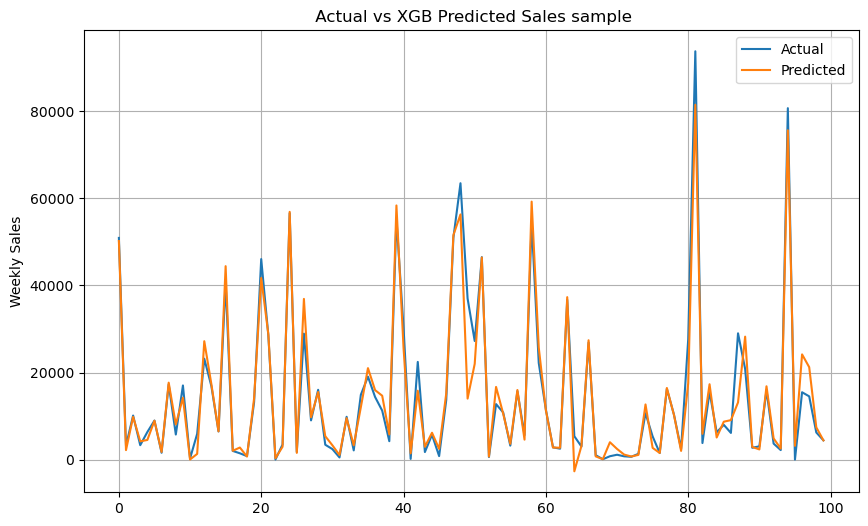

In [ ]:
# Plot the Comparison with before XGB and after XGB model.
plt.figure(figsize=(10, 6))
x = range(100)
plt.plot(x, test_y[:100], label='Actual')
plt.plot(x, y_pred[:100], label='Predicted')
plt.title(' Actual vs XGB Predicted Sales sample')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

This graph compares the actual weekly sales with the predicted sales from the XGBoost model. Overall, the predictions closely follow the actual sales trends, showing that the model captures the patterns well. However, there are some noticeable gaps, especially during the peaks, where the model underestimates or slightly overshoots the actual values. This suggests the model performs well but could be improved in predicting extreme sales spikes.